In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import random
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:
import wandb

api = wandb.Api()
entity, project, run_id = "psotoarenas", "RL_autoscalers", "2yfc2hxr"

def get_train_log(entity, project, run_id):
    run = api.run(entity + "/" + project + "/" + run_id)
    if run.state == "finished":
        print(f"Querying {run.name} with run_id {run.id}")
        root = os.path.join("./logs/", run.id)
        for file in run.files():
            if file.name.startswith("python") and file.name.endswith("traces"):
                logs = file.name
                print(f"Logs found with name {logs}")
        if not logs:
            logs = "output.log"
            print(f"No logs found. Downloading default logs {logs}")
        run.file(logs).download(root=root, replace=True)
        log_old_filename = os.path.join(root, logs)
        log_new_filename = os.path.join(root, f"{run.config['mode']}.traces")
        print(f"Saving train logfile to {log_new_filename}")
        os.rename(log_old_filename, log_new_filename)
    else: 
        print(f"Run with id {run_id} has not finished yet")
    return run.id, logs

def get_test_log(entity, project, run_id):
    runs = api.runs(entity + "/" + project)
    test_run_id = None
    for run in runs: 
        if run.config['mode'] == "test":
            train_run_id = run.config["run_id"].split('/')[-1]
            if train_run_id == run_id:
                test_run_id = run.id
                break
    if not test_run_id:
        print(f"There is no test for train run: {run_id}. Cannot retrieve logs")
    else:
        print(f"Test run found for train run with id: {run_id}. Downloading logs")
        root = os.path.join("./logs/", run_id)
        run = api.run(entity + "/" + project + "/" + test_run_id)
        for file in run.files():
            if file.name.startswith("python") and file.name.endswith("traces"):
                logs = file.name
                print(f"Logs found with name {logs}")
        if not logs:
            logs = "output.log"
            print(f"No logs found. Downloading default logs {logs}")
        run.file(logs).download(root=root, replace=True)
        log_old_filename = os.path.join(root, logs)
        log_new_filename = os.path.join(root, f"{run.config['mode']}.traces")
        print(f"Saving test logfile to {log_new_filename}")
        os.rename(log_old_filename, log_new_filename)
        
    return test_run_id, logs

train_run_id, train_traces = get_train_log(entity=entity, project=project, run_id=run_id)
test_run_id, test_traces = get_test_log(entity=entity, project=project, run_id=train_run_id)
print(f"Train ID: {train_run_id}")
print(f"Test ID: {test_run_id}")

Querying daily-sun-81 with run_id 2yfc2hxr
Logs found with name python-20220531-145833.traces
Saving train logfile to ./logs/2yfc2hxr/train.traces
Test run found for train run with id: 2yfc2hxr. Downloading logs
Logs found with name python-20220601-160951.traces
Saving test logfile to ./logs/2yfc2hxr/test.traces
Train ID: 2yfc2hxr
Test ID: hdml526a


In [3]:
root_folder = "./logs"
os.chdir(os.path.join(root_folder, train_run_id))
train_traces = "train.traces"
test_traces = "test.traces"

In [4]:
# Parse Results
# initialize dicts
modes = ["training", "testing"]
jobs = {key: [] for key in modes}
ms = {key: [] for key in modes}
cpu_usage = {key: [] for key in modes}
overflow = {key: [] for key in modes}
peak_latency = {key: [] for key in modes}
avg_latency = {key: [] for key in modes}
action = {key: [] for key in modes}
reward = {key: [] for key in modes}
cum_reward = {key: [] for key in modes}
reward_cum = {key: [] for key in modes}
current_timesteps = {key: [] for key in modes}
ticks = {key: [] for key in modes}
restarts_per_episode = {key: {} for key in modes}
timesteps = {}

act_2_meaning = {
    0: "increase",
    1: "decrease",
    2: "nothing"
}
       # Parse results
for mode in modes:
    if mode == "training":
        # open file for training traces
        traces_filename = train_traces
    else:
        # open file for training traces
        traces_filename = test_traces
    print(traces_filename)
    with open(traces_filename) as f:
        current_step = 0
        cumulative_reward = 0
        for line in f:
            try:
                line = line.rstrip().split("|")[-1]
                if line.startswith("Mode"):
                    mode = line.split(":")[-1].rstrip().split()[0]
                    timesteps[mode] = int(line.split(":")[-1].rstrip().split()[2])
                    if mode == "training": timesteps["base"] = int(line.split(":")[-1].rstrip().split()[-2])
                if line.startswith("Step"):
                    current_step = int(line.split(":")[-1].rstrip())
                    current_timesteps[mode].append(current_step)
                if line.startswith("Tick"):
                    tick = int(line.split(":")[-1].rstrip())
                    ticks[mode].append(tick)
                if line.startswith("Environment Reset"):
                    if not restarts_per_episode[mode]:
                        # dict is empty
                        restarts_per_episode[mode] = []
                    if current_step != 0:
                        # if it is not the first step
                        restarts_per_episode[mode].append(current_step)
                        cum_reward[mode].append(cumulative_reward)
                if line.startswith("Traffic"):
                    jobs[mode].append(int(line.split(":")[-1].rstrip()))
                if line.startswith("MS"):
                    ms[mode].append(int(line.split(":")[-1].rstrip()))
                if line.startswith("Cpu"):
                    cpu_usage[mode].append(float(line.split(":")[-1].rstrip()))
                if line.startswith("Overflow"):
                    overflow[mode].append(float(line.split(":")[-1].rstrip()))
                if line.startswith("Peak Latency"):
                    peak_latency[mode].append(float(line.split(":")[-1].rstrip()))
                if line.startswith("Avg Latency"):
                    avg_latency[mode].append(float(line.split(":")[-1].rstrip()))
                if line.startswith("Reward"):
                    reward[mode].append(float(line.split(":")[-1].rstrip()))
                if line.startswith("Cum Reward"):
                    cumulative_reward = float(line.split(":")[-1].rstrip())
                    reward_cum[mode].append(float(line.split(":")[-1].rstrip()))
                if line.startswith("Action"):
                    line = line.split(",")[0]
                    action[mode].append(act_2_meaning[int(line.split(":")[-1].rstrip())])
            except:
                print(line)
    if mode == "training":
        cum_reward["training"].append(cumulative_reward)
        restarts_per_episode["training"].append(current_step)
    else:
        cum_reward["testing"].append(cumulative_reward)
        restarts_per_episode["testing"].append(current_step)

train.traces
test.traces


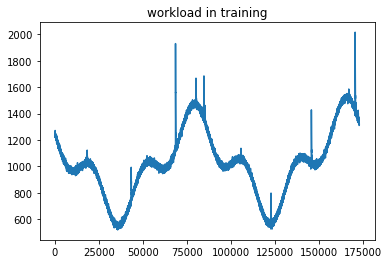

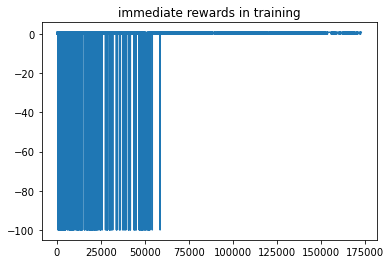

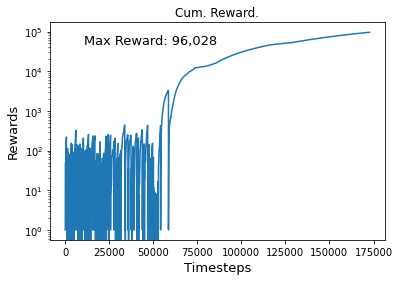

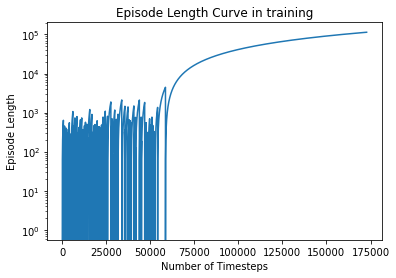

In [5]:
# train figures

fontsize=13
# --------------- workload ------------------------------
plt.figure()
plt.plot(np.array(jobs["training"]), label="workload")
plt.title("workload in training")
# plt.savefig('./workload_train.png', dpi=300)
plt.show()

# ---------------------------- immediate rewards  ---------------------------------------------------------
plt.figure()
plt.plot(np.array(reward["training"]))
plt.title("immediate rewards in training")
# plt.savefig('./rewards_train.png', dpi=300)
plt.show()

# ---------------------------- cumulative rewards (own) ---------------------------------------------------------
fig, ax = plt.subplots()
ax.plot(np.array(reward_cum["training"]))
ax.set_yscale('log')
ax.set_xlabel('Timesteps', fontsize=fontsize)
ax.set_ylabel('Rewards', fontsize=fontsize)
max_reward = int(max(np.array(reward_cum['training'])))
txt = f"Max Reward: {max_reward:,}"
ax.text(0.1, 0.9, txt, transform=ax.transAxes, fontsize=fontsize)
ax.set_title("Cum. Reward.")
# plt.savefig('./reward_cum_train.png', dpi=300)
plt.show()

# ---------------------------- episode length (own)  ---------------------------------------------------------
plt.figure()
plt.plot(np.array(current_timesteps["training"]))
plt.yscale('log')
plt.xlabel('Number of Timesteps')
plt.ylabel('Episode Length')
plt.title("Episode Length Curve in training")
# plt.savefig('./episode_len_train.png', dpi=300)
plt.show()

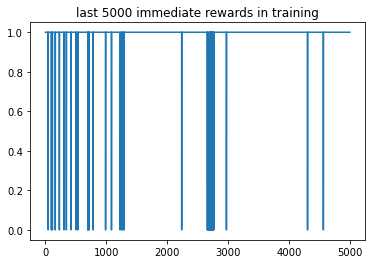

In [6]:
# ---------------------------- immediate rewards  ---------------------------------------------------------
plt.figure()
plt.plot(np.array(reward["training"])[-5000:])
plt.title("last 5000 immediate rewards in training")
# plt.savefig('./rewards_train.png', dpi=300)
plt.show()

In [7]:
# # --------------- num ms ------------------------------
# plt.figure()
# plt.plot(np.array(ms["training"]))
# plt.title("ms in training")
# plt.show()
# # --------------- cpu|overflow ------------------------------
# plt.figure()
# plt.plot(np.array(overflow["training"]), label="overflow")
# plt.plot(np.array(cpu_usage["training"]), label="cpu")
# plt.title("cpu|overflow in training")
# plt.legend()
# plt.show()

# # --------------- peak latency ------------------------------
# plt.figure()
# plt.plot(np.array(peak_latency["training"]))
# plt.title("peak_latency in training")
# plt.show
# # --------------- ticks ------------------------------
# plt.figure()
# plt.plot(np.array(ticks["training"]))
# plt.title("ticks in training")
# plt.show()

In [8]:
# # test figures
# # --------------- workload ------------------------------
# plt.figure()
# plt.plot(np.array(jobs["testing"]))
# plt.title("workload in testing")
# # plt.savefig('./workload_test.png', dpi=300)
# plt.show()

# # --------------- num ms ------------------------------
# plt.figure()
# plt.plot(np.array(ms["testing"]))
# plt.title("number of ms in testing")
# # plt.savefig('./ms_test.png', dpi=300)
# plt.show()

# # --------------- cpu|overflow ------------------------------
# plt.figure()
# plt.plot(np.array(overflow["testing"]), label="overflow")
# plt.plot(np.array(cpu_usage["testing"]), label="cpu")
# plt.ylim([0, 4])
# plt.title("cpu | overflow in testing")
# plt.legend()
# # plt.savefig('./cpu_overflow_test.png', dpi=300)
# plt.show()

# # --------------- peak latency ------------------------------
# plt.figure()
# plt.plot(np.array(peak_latency["testing"]))
# plt.ylim([0, 0.1])
# plt.title("peak latency[sec] in testing")
# # plt.savefig('./peak_latency_test.png', dpi=300)
# plt.show()

# # --------------- ticks ------------------------------
# plt.figure()
# plt.plot(np.array(ticks["testing"]))
# plt.title("ticks in testing")
# plt.show()

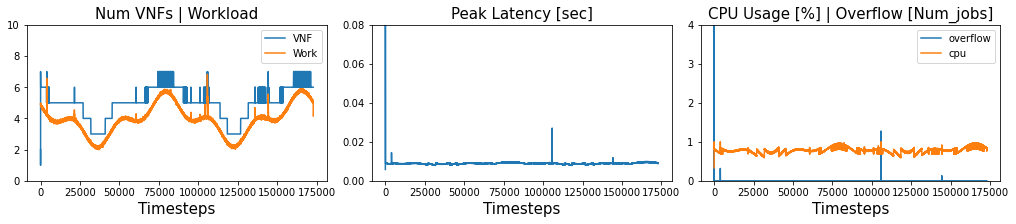

In [9]:
# plots for paper
fontsize=15

fig = plt.figure(constrained_layout=True, figsize=(14,3))
gs = GridSpec(1, 3, figure=fig)
# 
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(np.array(ms["testing"]), label='VNF')
ax1.plot(np.array(jobs["testing"])/300., label='Work')
ax1.set_ylim([0, 10])
ax1.set_xlabel('Timesteps', fontsize=fontsize)
ax1.set_title('Num VNFs | Workload', fontsize=fontsize)
ax1.legend()
# 
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(np.array(peak_latency["testing"]), label='peak_lat')
ax2.set_ylim([0, 0.08])
ax2.set_xlabel('Timesteps', fontsize=fontsize)
ax2.set_title('Peak Latency [sec]', fontsize=fontsize)
# 
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(np.array(overflow["testing"]), label='overflow')
ax3.plot(np.array(cpu_usage["testing"]), label='cpu')
ax3.set_ylim([0, 4])
ax3.set_xlabel('Timesteps', fontsize=fontsize)
ax3.set_title('CPU Usage [%] | Overflow [Num_jobs]', fontsize=fontsize)
ax3.legend()

# plt.savefig('./results_rl_paper.png', dpi=300)
plt.show()

In [10]:
# statistics
df = pd.DataFrame({'num_ms': ms["testing"], 'peak_latency': peak_latency["testing"]})
print(df.describe())

              num_ms   peak_latency
count  172801.000000  172801.000000
mean        5.012783       0.008919
std         0.957405       0.001817
min         1.000000       0.005810
25%         5.000000       0.008720
50%         5.000000       0.008890
75%         6.000000       0.009040
max         7.000000       0.187170


In [11]:
# SLO Violations
max_latency = 0.024
peak = np.array(peak_latency["testing"])
total_slo_measurements = len(peak)
peak = peak[peak>max_latency]
total_slo_violations = len(peak)
print(f"Total of SLO violations: {total_slo_violations}")
perc_slo_violations = total_slo_violations/total_slo_measurements
print(f"Percentage of SLO violations: {perc_slo_violations:2.2%}")

Total of SLO violations: 61
Percentage of SLO violations: 0.04%
